<a href="https://colab.research.google.com/github/Magnus-github/car-img-scorer/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car Image Scorer
A deep learning network that predicts the quality of pictures of cars for the use of damage assessment.

## Task
The task is to train a deep learning model to predict whether certain parts of a car are clearly visible in a given image. The predicted score should lie between **0.0** and **1.0**, where a score of 0.0 indicates that the part is not visible and a score of 1.0 means that the car part is clearly visible and in good light.

## Data
The dataset consists of 4000 synthetic images of cars from different angles and perspectives. For each image scores indicating the visibility of the hood and the left back door of the car are given.





In [1]:
# imports
!pip install torchviz
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import KFold
from PIL import Image
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=4e7075ea4820279b0c6614117f3815e513de37cf98097c6dd04d217f693af521
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


3200
torch.Size([3, 224, 224])
tensor([0., 0.])


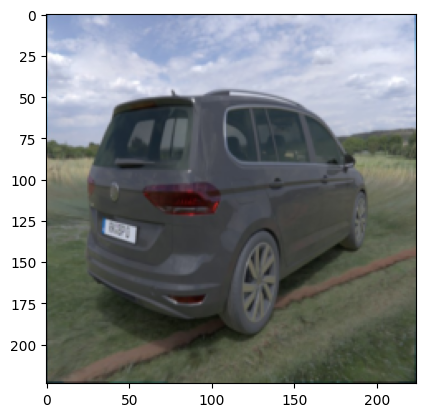

In [19]:
class CarImageDataset(Dataset):
    def __init__(self, root_dir: str, transform: transforms.Compose = None,
                 split: str = "train", num_folds: int = 10, fold: int = 0,
                 hparam_search: bool= False, seed: int = 42):
        self.img_dir = os.path.join(root_dir, "imgs")
        self.transform = transform
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
        #        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

        if hparam_search:
            # only train on 1/4 of the dataset
            reduced_dataset_size = len(os.listdir(self.img_dir))//4
            self.images = sorted(os.listdir(self.img_dir)[:reduced_dataset_size])
        else:
            self.images = sorted(os.listdir(self.img_dir))
        labels = pd.read_csv(os.path.join(root_dir, "car_imgs_4000.csv"))
        self.labels = {row["filename"]: [row["perspective_score_hood"], row["perspective_score_backdoor_left"]] for idx, row in labels.iterrows()}


        # split the data into 10 folds (9 for train/val and 1 for test)
        skf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
        splits = skf.split(list(range(len(self.images))))
        train_val_idx, test_idx = list(splits)[fold]

        train_val_imgs = [self.images[i] for i in train_val_idx]
        test_imgs = [self.images[i] for i in test_idx]

        # split train/val-split into 9 folds (8 for train and 1 for val)
        skf2 = KFold(n_splits=num_folds-1, random_state=seed, shuffle=True)
        splits2 = skf2.split(list(range(len(train_val_idx))))
        train_idx, val_idx = list(splits2)[0]

        if split == "train":
            self.images = [train_val_imgs[i] for i in train_idx]
        elif split == "val":
            self.images = [train_val_imgs[i] for i in val_idx]
        elif split == "test":
            self.images = test_imgs
        else:
            raise ValueError(f"Invalid split: {split}")


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.img_dir, self.images[idx])
        image = Image.open(image_path)
        if self.transform:
          image = self.transform(image)
        label = torch.tensor(self.labels[self.images[idx]])

        return image, label

root_dir = "/content/drive/MyDrive/CodingChallenge_HUK"
example = CarImageDataset(root_dir, hparam_search=False)
print(len(example))
example_img, example_label = example[0]
print(example_img.shape)
print(example_label)
plt.imshow(example_img.permute(1, 2, 0))
plt.show()


In [20]:
# function to get dataloaders
def get_dataloaders(root_dir: str, train_transform: transforms.Compose = None, val_transform: transforms.Compose = None, batch_size: int = 16, fold: int = 0, search: bool = False):
    train_dataset = CarImageDataset(root_dir=root_dir, transform=train_transform, split="train", fold=fold, hparam_search=search)
    val_dataset = CarImageDataset(root_dir=root_dir, transform=val_transform, split="val", fold=fold, hparam_search=search)
    test_dataset = CarImageDataset(root_dir=root_dir, transform=val_transform, split="test", fold=fold, hparam_search=search)

    for test_file in test_dataset.images:
        assert test_file not in train_dataset.images, f"Test file{test_file} in train set"
        assert test_file not in val_dataset.images, f"Test file{test_file} in val set"
    for val_file in val_dataset.images:
        assert val_file not in train_dataset.images, f"Val file{val_file} in train set"

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    return {"train": train_dataloader, "val": val_dataloader, "test": test_dataloader}

dataloaders = get_dataloaders(root_dir, search=False)
print(len(dataloaders["train"]))
print(len(dataloaders["val"]))
print(len(dataloaders["test"]))

200
400
400


## Model
Since we are doing a regression task on images, I have decided to implement a simple convolutional neural network (CNN). CNNs are great at deep learning tasks involving pictures as input, e.g. object detection, image classification, or image segmentation. They usually consist of convolutional layers and pooling layers followed by fully connected linear layers to produce the desired output.

CNNImageScorer(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=401408, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)
torch.Size([1, 2])


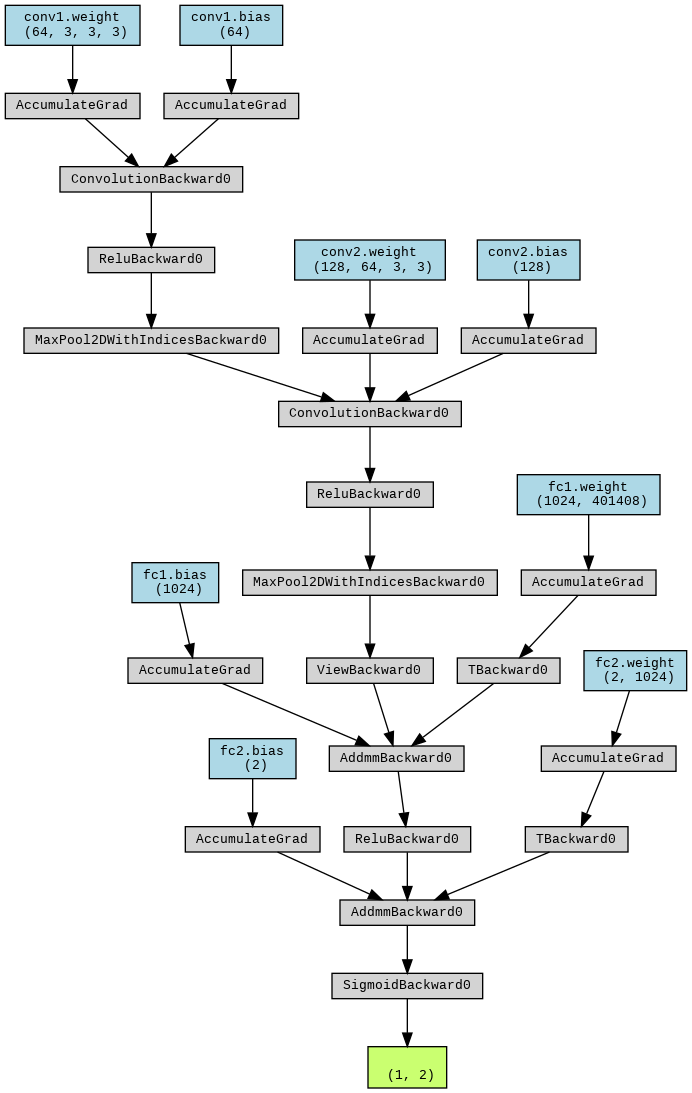

In [21]:
from torch import nn
import torch.nn.functional as F
from torchviz import make_dot



class CNNImageScorer(nn.Module):
    def __init__(self, img_size: int = 224, num_channels: int = 64, num_scores: int = 2):
        super(CNNImageScorer, self).__init__()
        self.conv1 = nn.Conv2d(3, num_channels, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(num_channels, 2*num_channels, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        fc_size = 2*num_channels * (img_size // 4) * (img_size // 4)
        self.fc1 = nn.Linear(fc_size, 1024)
        self.fc2 = nn.Linear(1024, num_scores)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x


example = CNNImageScorer()
example_input = torch.randn(1, 3, 224, 224)
example_output = example(example_input)
print(example)
print(example_output.shape)
make_dot(example_output, params=dict(list(example.named_parameters()))).render("cnn", format="png")
from IPython import display
display.Image(filename='cnn.png')

## Training
The following cell implements the training loop for learning the correct weights of our model. The weights are updated based on the mean-squared-error (**MSE**) loss function between the predicted and actual values.

In [22]:
import logging
from tqdm import tqdm
from sklearn.metrics import r2_score, mean_squared_error


class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# trainer class implmenting training, validation and testing
class Trainer:
    def __init__(self, dataloaders: dict[DataLoader], hparams: dict, save_dir: str) -> None:
        self.logger = logging.getLogger(self.__class__.__name__)
        self.logger.setLevel(level=logging.INFO)

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        id = len(os.listdir(save_dir))
        self.save_path = os.path.join(save_dir, f"model_{id}.pth")

        self.hparams = hparams
        self.epochs = hparams["epochs"]
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = CNNImageScorer(img_size=self.hparams["input_size"], num_channels=self.hparams["num_channels"])
        self.model.to(self.device)
        self.train_dataloader = dataloaders["train"]
        self.val_dataloader = dataloaders["val"]
        self.test_dataloader = dataloaders["test"]
        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.hparams["lr"])
        self.early_stopper = EarlyStopper(patience=3, min_delta=0.001)

        self.logger.info(f"Device: {self.device}")


    def train(self, save_model: bool = False, verbose: bool = False):
        self.model.train()
        self.logger.info("Starting training...")
        for epoch in range(self.epochs):
            self.logger.info(f"Epoch {epoch+1}/{self.epochs}")
            running_loss = 0.0
            for i, (X, y) in enumerate(tqdm(self.train_dataloader)):
                X, y = X.to(self.device), y.to(self.device)

                pred = self.model(X)
                loss = self.loss_fn(pred, y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

            val_loss = self.val()
            if verbose:
                self.logger.info(f"Epoch {epoch+1} training loss: {running_loss/len(self.train_dataloader)}")
                self.logger.info(f"Epoch {epoch+1} validation loss: {val_loss}")
            if self.early_stopper.early_stop(val_loss):
                self.logger.info("Early stopping...")
                break
        if save_model:
          self.save_model()
        self.logger.info("Training completed!")
        return {"best_val_loss": self.early_stopper.min_validation_loss, "last_val_loss": val_loss}

    def val(self):
        self.model.eval()
        with torch.no_grad():
            running_loss = 0.0
            for i, (X, y) in enumerate(self.val_dataloader):
                X, y = X.to(self.device), y.to(self.device)
                pred = self.model(X)
                loss = self.loss_fn(pred, y)
                running_loss += loss.item()
            return running_loss/len(self.val_dataloader)

    def save_model(self):
        torch.save(self.model.state_dict(), self.save_path)


    def test(self, model_path: str, verbose: bool = False):
        self.model.load_state_dict(torch.load(model_path))
        self.model.eval()
        with torch.no_grad():
            running_loss = 0.0
            pred_hood = []
            pred_backdoor = []
            true_hood = []
            true_backdoor = []
            for i, (X, y) in enumerate(self.test_dataloader):
                true_hood.append(y[0,0].item())
                true_backdoor.append(y[0,1].item())
                X, y = X.to(self.device), y.to(self.device)
                pred = self.model(X)
                loss = self.loss_fn(pred, y)
                running_loss += loss.item()
                pred_hood.append(pred.cpu()[0,0].item())
                pred_backdoor.append(pred.cpu()[0,1].item())
                pred_dict = {
                    "Predicted visibility hood": pred.cpu()[0,0].item(),
                    "Predicted visibility left back door": pred.cpu()[0,1].item()
                }
                true_dict = {
                    "True visibility hood": y.cpu()[0,0].item(),
                    "True visibility left back door": y.cpu()[0,1].item()
                }
                if verbose:
                    self.logger.info(f"Predicted visibility: {pred_dict}")
                    self.logger.info(f"True visibility: {true_dict}")
                    self.logger.info(f"Test loss: {loss.item()}")

        r2_hood = r2_score(true_hood, pred_hood)
        r2_backdoor = r2_score(true_backdoor, pred_backdoor)
        mse_hood = mean_squared_error(true_hood, pred_hood)
        mse_backdoor = mean_squared_error(true_backdoor, pred_backdoor)
        average_test_loss = running_loss/len(self.test_dataloader)
        self.logger.info(f"R2 score for hood: {r2_hood}")
        self.logger.info(f"R2 score for backdoor: {r2_backdoor}")
        self.logger.info(f"MSE for hood: {mse_hood}")
        self.logger.info(f"MSE for backdoor: {mse_backdoor}")
        self.logger.info(f"Average test MSE: {average_test_loss}")

        return {"MSE_hood": mse_hood, "MSE_backdoor": mse_backdoor, "r2_hood": r2_hood, "r2_backdoor": r2_backdoor}


## Hyperparameter search

We will perform a small hyperparameter grid search to find good values for the learning rate and batch size. To reduce the computational time, we perform the search on 1/4th of the original dataset and only train for 5 epochs (instead of 10).

In [23]:
root_dir = "/content/drive/MyDrive/CodingChallenge_HUK"
save_dir = os.path.join(root_dir, "models")
hparams = {
    "input_size": 224,
    "num_channels": 64,
    "epochs": 5,
    "lr": 0.01,
    "batch_size": 16
}
train_transform = transforms.Compose([
                transforms.Resize((hparams["input_size"], hparams["input_size"])),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
val_transform = train_transform

# hyperparameter search
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [8, 16, 32]

validation_losses = []
for i, lr in enumerate(learning_rates):
    val_losses = []
    for j, batch_size in enumerate(batch_sizes):
        hparams["lr"] = lr
        hparams["batch_size"] = batch_size
        dataloaders = get_dataloaders(root_dir, train_transform, val_transform, batch_size=batch_size, search=True)
        trainer = Trainer(dataloaders, hparams, save_dir)
        val_metrics = trainer.train()
        val_losses.append(val_metrics["best_val_loss"])
    validation_losses.append(val_losses)

validation_losses = np.array(validation_losses)
min_idx = np.unravel_index(validation_losses.argmin(),validation_losses.shape)
print(f"Best learning rate: {learning_rates[min_idx[0]]}")
print(f"Best batch size: {batch_sizes[min_idx[1]]}")


INFO:Trainer:Device: cuda
INFO:Trainer:Starting training...
INFO:Trainer:Epoch 1/5
100%|██████████| 100/100 [00:53<00:00,  1.86it/s]
INFO:Trainer:Epoch 2/5
100%|██████████| 100/100 [00:13<00:00,  7.48it/s]
INFO:Trainer:Epoch 3/5
100%|██████████| 100/100 [00:13<00:00,  7.38it/s]
INFO:Trainer:Epoch 4/5
100%|██████████| 100/100 [00:13<00:00,  7.45it/s]
INFO:Trainer:Epoch 5/5
100%|██████████| 100/100 [00:13<00:00,  7.39it/s]
INFO:Trainer:Training completed!
INFO:Trainer:Device: cuda
INFO:Trainer:Starting training...
INFO:Trainer:Epoch 1/5
100%|██████████| 50/50 [00:55<00:00,  1.12s/it]
INFO:Trainer:Epoch 2/5
100%|██████████| 50/50 [00:11<00:00,  4.44it/s]
INFO:Trainer:Epoch 3/5
100%|██████████| 50/50 [00:11<00:00,  4.41it/s]
INFO:Trainer:Epoch 4/5
100%|██████████| 50/50 [00:11<00:00,  4.36it/s]
INFO:Trainer:Epoch 5/5
100%|██████████| 50/50 [00:11<00:00,  4.41it/s]
INFO:Trainer:Training completed!
INFO:Trainer:Device: cuda
INFO:Trainer:Starting training...
INFO:Trainer:Epoch 1/5
100%|██████

Best learning rate: 0.1
Best batch size: 8


## Train with best hyperparameters

Finally, we train the model on the entire dataset (3200 train images) for 10 epochs with the best values for learning rate and batch size that we determined above.

In [25]:
lr = learning_rates[min_idx[0]]
batch_size = batch_sizes[min_idx[1]]
hparams = {
    "input_size": 224,
    "num_channels": 64,
    "epochs": 10,
    "lr": lr,
    "batch_size": batch_size
}
print(hparams)
dataloaders = get_dataloaders(root_dir, train_transform, val_transform, batch_size=hparams["batch_size"])
trainer = Trainer(dataloaders, hparams, save_dir)
trainer.train(save_model=True, verbose=True)

{'input_size': 224, 'num_channels': 64, 'epochs': 10, 'lr': 0.1, 'batch_size': 8}


INFO:Trainer:Device: cuda
INFO:Trainer:Starting training...
INFO:Trainer:Epoch 1/10
100%|██████████| 400/400 [01:35<00:00,  4.19it/s]
INFO:Trainer:Epoch 1 training loss: 0.09347259950824081
INFO:Trainer:Epoch 1 validation loss: 0.058838766808148646
INFO:Trainer:Epoch 2/10
100%|██████████| 400/400 [00:59<00:00,  6.75it/s]
INFO:Trainer:Epoch 2 training loss: 0.051690531682688744
INFO:Trainer:Epoch 2 validation loss: 0.05020365028460617
INFO:Trainer:Epoch 3/10
100%|██████████| 400/400 [00:54<00:00,  7.40it/s]
INFO:Trainer:Epoch 3 training loss: 0.03196538281423272
INFO:Trainer:Epoch 3 validation loss: 0.05177359991637673
INFO:Trainer:Epoch 4/10
100%|██████████| 400/400 [00:54<00:00,  7.37it/s]
INFO:Trainer:Epoch 4 training loss: 0.016314100463932845
INFO:Trainer:Epoch 4 validation loss: 0.048662368065610015
INFO:Trainer:Epoch 5/10
100%|██████████| 400/400 [00:57<00:00,  7.00it/s]
INFO:Trainer:Epoch 5 training loss: 0.008030237344210036
INFO:Trainer:Epoch 5 validation loss: 0.0464984637175

{'best_val_loss': 0.044640271877553275, 'last_val_loss': 0.045118105752056575}

## Testing

Finally, test the trained model on the held-out test set. The performance on the test set is measured by the MSE and the R2-score for the two car parts (hood and backdoor).

In [27]:
# Test best model
model_path = "/content/drive/MyDrive/CodingChallenge_HUK/models/model_1.pth"

trainer.test(model_path, verbose=True)

<ipython-input-22-1fd18d190443>:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path))
INFO:Trainer:Predicted visibility: {'Pre

{'MSE_hood': 0.03940551322622499,
 'MSE_backdoor': 0.06238669779743664,
 'r2_hood': 0.7180714865205027,
 'r2_backdoor': 0.5582689132239027}

## Extra: k-fold cross-validation

To further evaluate the model, we can do k-fold cross validation (e.g. with k=10) to see how well the model generalises. If there is no large variance between the test results for the different folds, this indicates good generalisability. Due to large computational demand of 10-fold cross-validation, we will not execute the following code.

In [ ]:
# Perform cross-validation to evaluate the model
cross_val_metrics = {"MSE_hood": [], "MSE_backdoor": [], "r2_hood": [], "r2_backdoor": []}
for fold in range(10):
    dataloaders = get_dataloaders(root_dir, train_transform, val_transform, batch_size=hparams["batch_size"], fold=fold)
    trainer = Trainer(dataloaders, hparams, save_dir)
    trainer.train()
    test_metrics = trainer.test(trainer.save_path)
    for key in cross_val_metrics.keys():
        cross_val_metrics[key].append(test_metrics[key])

for key in cross_val_metrics.keys():
    metric = np.array(cross_val_metrics[key])
    metric_mean = np.mean(metric)
    metric_std = np.std(metric)
    print(f"{key} mean: {metric_mean}")
    print(f"{key} std: {metric_std}")



## Improvements

Lastly, I would like to address potential improvements if there was more time for the task.

*   Data augmentation
*   More extensive hyperparameter search including model parameters (filter size, depth, number of channels, etc.)
*   Adaptive learning rate

